## Modelado y Evaluación

La estadística descriptiva confirma la alta dispersión y asimetría de los precios del Bitcoin, un rasgo que justifica el análisis posterior de la volatilidad como variable fundamental en modelos predictivos.

In [ ]:
#funcional mlp perfecto
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tsxv.splitTrainValTest import split_train_val_test_groupKFold
from collections import Counter

# ---------------------------
# Utilidades
# ---------------------------
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12))) * 100.0

def bds_test(residuals, max_dim=3, eps_factor=0.5, n_bootstrap=200, random_state=42):
    np.random.seed(random_state)
    n = len(residuals)
    eps = eps_factor * np.std(residuals)

    def embed(data, m):
        return np.array([data[i:i + m] for i in range(n - m + 1)])

    def correlation_integral(X, eps):
        N = len(X)
        count = 0
        for i in range(N):
            count += np.sum(np.linalg.norm(X - X[i], axis=1) < eps)
        return count / (N * N)

    results = []
    for m in range(2, max_dim + 1):
        Xm = embed(residuals, m)
        X1 = embed(residuals, 1)
        Cm = correlation_integral(Xm, eps)
        C1 = correlation_integral(X1, eps)
        bds_stat = np.sqrt(n) * (Cm - C1**m)

        boot_stats = []
        for _ in range(n_bootstrap):
            shuffled = np.random.permutation(residuals)
            Xm_boot = embed(shuffled, m)
            Cmb = correlation_integral(Xm_boot, eps)
            C1b = correlation_integral(embed(shuffled, 1), eps)
            boot_stats.append(np.sqrt(n) * (Cmb - C1b**m))
        boot_stats = np.array(boot_stats)
        p_value = (np.sum(np.abs(boot_stats) >= np.abs(bds_stat)) + 1) / (n_bootstrap + 1)
        results.append((m, bds_stat, p_value))

    return pd.DataFrame(results, columns=['m', 'statistic', 'p_value']).set_index("m")

# ---------------------------
# Carga de datos
# ---------------------------
btc = pd.read_csv("btc_1d_data_2018_to_2025.csv")
btc = btc[["Open time", "Close"]].dropna().reset_index(drop=True)
btc = btc.rename(columns={"Open time": "Date"})
btc["Close"] = btc["Close"].astype(float)
btc["LogReturn"] = np.log(btc["Close"] / btc["Close"].shift(1))

window_size = 7
btc["Volatility"] = btc["LogReturn"].rolling(window=window_size).std() * np.sqrt(365)
btc = btc.sort_values("Date").reset_index(drop=True).dropna().reset_index(drop=True)

volatility_full = btc["Volatility"].values

# ---------------------------
# Configuración de experimento
# ---------------------------
n_steps_in_list = [7, 14, 21, 28]
n_steps_out = 7
n_steps_jump = 1  # Máxima densidad de datos


mlp_hyperparams = []

# Arquitecturas enfocadas en las que funcionaron bien
hidden_layers = [
    (10,), (20,), (30,), (50,), (100,), (200,),  # Capas simples
    (20, 10), (30, 15), (50, 20), (100, 50), (200, 100)  # Dos capas
]

# Activaciones que mostraron buenos resultados
activations = ["relu", "tanh"]

# Rango amplio de alpha incluyendo los exitosos
alphas = [1e-5, 1e-4, 1e-3, 1e-2]

# Learning rates enfocados en los exitosos
learning_rates = [1e-4, 5e-4, 1e-3, 5e-3]

# Max_iter variado
max_iters = [500, 1000]

# Solo StandardScaler (funcionó bien antes)
scaler_type = "standard"

for hidden in hidden_layers:
    for activation in activations:
        for alpha in alphas:
            for lr in learning_rates:
                for max_iter in max_iters:
                    mlp_hyperparams.append({
                        "hidden_layer_sizes": hidden,
                        "activation": activation,
                        "alpha": alpha,
                        "learning_rate_init": lr,
                        "max_iter": max_iter,
                        "scaler": scaler_type
                    })

print(f"CONFIGURACIÓN ENFOCADA EN HIPERPARÁMETROS EXITOSOS:")
print(f"  - Total hyperparam combos: {len(mlp_hyperparams)}")
print(f"  - Cálculo: {len(hidden_layers)}×{len(activations)}×{len(alphas)}×{len(learning_rates)}×{len(max_iters)} = {len(hidden_layers)*len(activations)*len(alphas)*len(learning_rates)*len(max_iters)}")
print(f"  - Architecturas: {len(hidden_layers)} opciones (incluyendo las exitosas: 50, 200)")
print(f"  - Activaciones: {activations}")
print(f"  - Alphas: {alphas} (incluyendo 1e-5, 1e-4, 1e-3 que funcionaron)")
print(f"  - Learning rates: {learning_rates}")
print(f"  - Max_iter: {max_iters}")
print(f"  - Scaler: Solo StandardScaler")

summary_rows = []

# ---------------------------
# Loop principal
# ---------------------------
for n_steps_in in n_steps_in_list:
    print(f"\n=== LAG {n_steps_in} ===")
    X, y, Xcv, ycv, Xtest, ytest = split_train_val_test_groupKFold(
        volatility_full,
        n_steps_in,
        n_steps_out,
        n_steps_jump
    )
    
    print(f"Datos con n_steps_jump={n_steps_jump}:")
    print(f"  - Número de folds: {len(X)}")
    if len(X) > 0:
        # Verificar si X contiene arrays o enteros
        try:
            if hasattr(X[0], '__len__'):  # Es un array
                print(f"  - Tamaño promedio train: {np.mean([len(x) for x in X]):.0f} muestras")
                print(f"  - Tamaño promedio val: {np.mean([len(x) for x in Xcv]):.0f} muestras")
                print(f"  - Tamaño promedio test: {np.mean([len(x) for x in Xtest]):.0f} muestras")
            else:  # Es un entero o escalar
                print(f"  - Tamaños train: {[x.shape[0] if hasattr(x, 'shape') else len(x) for x in X]}")
                print(f"  - Tamaños val: {[x.shape[0] if hasattr(x, 'shape') else len(x) for x in Xcv]}")
                print(f"  - Tamaños test: {[x.shape[0] if hasattr(x, 'shape') else len(x) for x in Xtest]}")
        except Exception as e:
            print(f"  - Error al calcular tamaños: {e}")
            print(f"  - Tipo de X[0]: {type(X[0])}")
            print(f"  - Forma de X[0]: {X[0].shape if hasattr(X[0], 'shape') else 'No shape'}")

    folds_stats, folds_bds, folds_best_cfg = [], [], []

    for fold in range(len(X)):
        print(f"\n  Procesando Fold {fold+1}/{len(X)}...")
        Xtr, ytr = X[fold], y[fold]
        Xval, yval = Xcv[fold], ycv[fold]
        Xte, yte = Xtest[fold], ytest[fold]

        best_cfg, best_rmse, best_model, best_scaler_x, best_scaler_y = None, np.inf, None, None, None

        # Búsqueda exhaustiva en validación con progreso
        for cfg_idx, cfg in enumerate(mlp_hyperparams):
            if cfg_idx % 50 == 0:  # Progreso cada 50 configs
                print(f"    Evaluando config {cfg_idx+1}/{len(mlp_hyperparams)}... ({100*cfg_idx/len(mlp_hyperparams):.1f}%)")
            
            # Solo StandardScaler (simplificado)
            scaler_x = StandardScaler()
            scaler_y = StandardScaler()

            Xtr_s = scaler_x.fit_transform(Xtr)
            ytr_s = scaler_y.fit_transform(ytr)
            Xval_s = scaler_x.transform(Xval)

            model = MLPRegressor(
                hidden_layer_sizes=cfg["hidden_layer_sizes"],
                activation=cfg["activation"],
                alpha=cfg["alpha"],
                learning_rate_init=cfg["learning_rate_init"],
                max_iter=cfg["max_iter"],
                random_state=42,
                early_stopping=True,
                validation_fraction=0.15,
                n_iter_no_change=15  # Reducido de 20 para acelerar
            )

            try:
                model.fit(Xtr_s, ytr_s)
                yval_hat = scaler_y.inverse_transform(model.predict(Xval_s))
                rmse_val = np.mean([
                    np.sqrt(mean_squared_error(yval[:, h], yval_hat[:, h]))
                    for h in range(n_steps_out)
                ])

                if rmse_val < best_rmse:
                    best_rmse, best_cfg, best_model = rmse_val, cfg, model
                    best_scaler_x, best_scaler_y = scaler_x, scaler_y
            except:
                # Si falla el entrenamiento, continuar con siguiente config
                continue

        folds_best_cfg.append(best_cfg)
        print(f"    Mejor RMSE validación: {best_rmse:.4f}")
        print(f"    Mejor config: {best_cfg}")

        # RETRAIN: train+val
        Xtrain_full = np.vstack([Xtr, Xval])
        ytrain_full = np.vstack([ytr, yval])
        
        final_scaler_x = StandardScaler()
        final_scaler_y = StandardScaler()
        
        Xtrain_full_s = final_scaler_x.fit_transform(Xtrain_full)
        ytrain_full_s = final_scaler_y.fit_transform(ytrain_full)

        final_model = MLPRegressor(
            hidden_layer_sizes=best_cfg["hidden_layer_sizes"],
            activation=best_cfg["activation"],
            alpha=best_cfg["alpha"],
            learning_rate_init=best_cfg["learning_rate_init"],
            max_iter=best_cfg["max_iter"],
            random_state=42,
            early_stopping=True,
            validation_fraction=0.15,
            n_iter_no_change=15
        )
        final_model.fit(Xtrain_full_s, ytrain_full_s)

        # Predicciones en test
        Xte_s = final_scaler_x.transform(Xte)
        yte_hat = final_scaler_y.inverse_transform(final_model.predict(Xte_s))
        yte_real = yte

        # Métricas por horizonte
        metrics_per_h = []
        for h in range(n_steps_out):
            mae_h = mean_absolute_error(yte_real[:, h], yte_hat[:, h])
            mse_h = mean_squared_error(yte_real[:, h], yte_hat[:, h])
            rmse_h = np.sqrt(mse_h)
            mape_h = mape(yte_real[:, h], yte_hat[:, h])
            metrics_per_h.append((mae_h, mse_h, rmse_h, mape_h))

        mae_mean = np.mean([m[0] for m in metrics_per_h])
        mse_mean = np.mean([m[1] for m in metrics_per_h])
        rmse_mean = np.mean([m[2] for m in metrics_per_h])
        mape_mean = np.mean([m[3] for m in metrics_per_h])

        # BDS test en residuos horizonte 1
        resid_h1 = yte_real[:, 0] - yte_hat[:, 0]
        bds_df = bds_test(resid_h1, n_bootstrap=200)
        bds_pval_h1 = bds_df.loc[2, "p_value"]

        folds_stats.append({
            "fold": fold,
            "rmse_mean": rmse_mean,
            "mae_mean": mae_mean,
            "mse_mean": mse_mean,
            "mape_mean": mape_mean,
            "per_h_metrics": metrics_per_h
        })
        folds_bds.append(bds_pval_h1)

        print(f"    Test final: MAE={mae_mean:.4f}, RMSE={rmse_mean:.4f}, MAPE={mape_mean:.2f}%, BDS={bds_pval_h1:.4f}")

    # Resumen por lag
    rmse_arr = np.array([s["rmse_mean"] for s in folds_stats])
    mae_arr  = np.array([s["mae_mean"] for s in folds_stats])
    mse_arr  = np.array([s["mse_mean"] for s in folds_stats])
    mape_arr = np.array([s["mape_mean"] for s in folds_stats])
    bds_arr  = np.array(folds_bds)

    best_cfg_mode = Counter([str(cfg) for cfg in folds_best_cfg]).most_common(1)[0][0]

    print(f"\n--- RESUMEN LAG {n_steps_in} ---")
    print(f" Mejor config (moda): {best_cfg_mode}")
    print(f" MAE:  {np.mean(mae_arr):.4f} ± {np.std(mae_arr):.4f}")
    print(f" MSE:  {np.mean(mse_arr):.4f} ± {np.std(mse_arr):.4f}")
    print(f" RMSE: {np.mean(rmse_arr):.4f} ± {np.std(rmse_arr):.4f}")
    print(f" MAPE: {np.mean(mape_arr):.2f} ± {np.std(mape_arr):.2f}%")
    print(f" BDS:  {np.mean(bds_arr):.4f} ± {np.std(bds_arr):.4f}")

    summary_rows.append({
        "Lag": n_steps_in,
        "Best_cfg_mode": best_cfg_mode,
        "MAE_mean": np.mean(mae_arr), "MAE_std": np.std(mae_arr),
        "MSE_mean": np.mean(mse_arr), "MSE_std": np.std(mse_arr),
        "RMSE_mean": np.mean(rmse_arr), "RMSE_std": np.std(rmse_arr),
        "MAPE_mean": np.mean(mape_arr), "MAPE_std": np.std(mape_arr),
        "BDS_mean": np.mean(bds_arr), "BDS_std": np.std(bds_arr)
    })

# Resumen final comparativo
df_final = pd.DataFrame(summary_rows)
print(f"\n{'='*60}")
print("RESUMEN FINAL COMPARATIVO (n_steps_jump=1)")
print(f"{'='*60}")
print(df_final.to_string(index=False))

print(f"\nCOMPUTACIÓN COMPLETADA:")
print(f"  - Configuraciones evaluadas: {len(mlp_hyperparams)} por fold")
print(f"  - Total evaluaciones aproximadas: {len(mlp_hyperparams) * len(n_steps_in_list) * 'avg_folds'}")
print(f"  - Reducción vs original: {100*(1-len(mlp_hyperparams)/1344):.1f}% menos configuraciones")
print(f"  - Uso de datos: Máximo (n_steps_jump=1)")

# Identificar mejor lag
best_lag_idx = np.argmin([row["RMSE_mean"] for row in summary_rows])
best_lag = summary_rows[best_lag_idx]["Lag"]
print(f"\nMEJOR LAG: {best_lag} (RMSE promedio: {summary_rows[best_lag_idx]['RMSE_mean']:.4f})")

CONFIGURACIÓN ENFOCADA EN HIPERPARÁMETROS EXITOSOS:
  - Total hyperparam combos: 704
  - Cálculo: 11×2×4×4×2 = 704
  - Architecturas: 11 opciones (incluyendo las exitosas: 50, 200)
  - Activaciones: ['relu', 'tanh']
  - Alphas: [1e-05, 0.0001, 0.001, 0.01] (incluyendo 1e-5, 1e-4, 1e-3 que funcionaron)
  - Learning rates: [0.0001, 0.0005, 0.001, 0.005]
  - Max_iter: [500, 1000]
  - Scaler: Solo StandardScaler

=== LAG 7 ===
Datos con n_steps_jump=1:
  - Número de folds: 5
  - Error al calcular tamaños: object of type 'numpy.int32' has no len()
  - Tipo de X[0]: <class 'numpy.ndarray'>
  - Forma de X[0]: (337, 7)

  Procesando Fold 1/5...
    Evaluando config 1/704... (0.0%)
    Evaluando config 51/704... (7.1%)
    Evaluando config 101/704... (14.2%)
    Evaluando config 151/704... (21.3%)
    Evaluando config 201/704... (28.4%)
    Evaluando config 251/704... (35.5%)
    Evaluando config 301/704... (42.6%)
    Evaluando config 351/704... (49.7%)
    Evaluando config 401/704... (56.8%)


ya que no tiene un alto costo computacional por la relativamente pequena cantidad de datos, fuimos capaces de probar una gran cantidad de hiperparametros con la densidad maxima es decir n_jumps=1.
podemos observar un BDS que no rechaza la hipotesis nula de independenica en ningn caso, es decir no hay evidencia estadisticamente significativa como para afirmar que haya dependecia en la serie temporal.

estos resultados si bien buenos podriamos buscar en otros modelos mejor capacidad de prediccion, especialmente para ventanas de aprendizaje mas grandes, una opcion podria ser lstm.


In [ ]:
#lstm good largo nsteps1
# hide-output
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tsxv.splitTrainValTest import split_train_val_test_groupKFold

# -------- utils --------
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12))) * 100.0

def build_lstm(input_shape, units, dropout, lr, n_layers=1):
    model = Sequential()
    for i in range(n_layers):
        return_seq = (i < n_layers - 1)  # return_sequences True si no es la última capa
        model.add(LSTM(units, input_shape=input_shape if i == 0 else None,
                       return_sequences=return_seq))
        if dropout > 0:
            model.add(Dropout(dropout))
    model.add(Dense(n_steps_out))  # salida multistep
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model

# -------- datos --------
btc = pd.read_csv('btc_1d_data_2018_to_2025.csv')
btc = btc[['Open time', 'Close']].dropna().reset_index(drop=True)
btc = btc.rename(columns={'Open time': 'Date'})
btc['Close'] = btc['Close'].astype(float)
btc['LogReturn'] = np.log(btc['Close'] / btc['Close'].shift(1))
window_size = 7
btc['Volatility'] = btc['LogReturn'].rolling(window=window_size).std() * np.sqrt(365)
btc = btc.dropna().reset_index(drop=True)
volatility_full = btc['Volatility'].values

# -------- params --------
n_steps_out = 7
n_steps_jump = 1
lags_to_try = [21, 28]

param_grid = []
for units in [32, 64, 128]:
    for dropout in [0.0, 0.2, 0.5]:
        for lr in [0.001, 0.0005]:
            for batch_size in [32, 64]:
                for n_layers in [1, 2]:  # 1 o 2 capas LSTM
                    param_grid.append({
                        "units": units,
                        "dropout": dropout,
                        "lr": lr,
                        "batch_size": batch_size,
                        "n_layers": n_layers
                    })

print(f"Total configs: {len(param_grid)}")

# -------- experimento --------
for n_steps_in in lags_to_try:
    print(f"\n=== LAG {n_steps_in} con LSTM ===")
    X, y, Xcv, ycv, Xtest, ytest = split_train_val_test_groupKFold(
        volatility_full,
        n_steps_in,
        n_steps_out,
        n_steps_jump
    )

    folds_stats = []
    for fold in range(len(X)):
        print(f"\n--- Fold {fold+1} ---")
        Xtr, ytr = X[fold], y[fold]
        Xval, yval = Xcv[fold], ycv[fold]
        Xte, yte = Xtest[fold], ytest[fold]

        # Escalado
        scaler_x = StandardScaler()
        scaler_y = StandardScaler()
        Xtr_s = scaler_x.fit_transform(Xtr)
        ytr_s = scaler_y.fit_transform(ytr)
        Xval_s = scaler_x.transform(Xval)
        yval_s = scaler_y.transform(yval)
        Xte_s = scaler_x.transform(Xte)

        # reshape para LSTM [samples, timesteps, features]
        Xtr_s = Xtr_s.reshape((Xtr_s.shape[0], Xtr_s.shape[1], 1))
        Xval_s = Xval_s.reshape((Xval_s.shape[0], Xval_s.shape[1], 1))
        Xte_s = Xte_s.reshape((Xte_s.shape[0], Xte_s.shape[1], 1))

        # búsqueda manual
        best_cfg, best_rmse, best_model = None, np.inf, None
        for cfg in param_grid:
            model = build_lstm((n_steps_in, 1), cfg["units"], cfg["dropout"], cfg["lr"], cfg["n_layers"])
            model.fit(Xtr_s, ytr_s,
                      validation_data=(Xval_s, yval_s),
                      epochs=100, batch_size=cfg["batch_size"], verbose=0)
            yval_hat = scaler_y.inverse_transform(model.predict(Xval_s))
            rmse_val = np.mean([np.sqrt(mean_squared_error(yval[:,h], yval_hat[:,h])) for h in range(n_steps_out)])
            if rmse_val < best_rmse:
                best_rmse, best_cfg, best_model = rmse_val, cfg, model

        print(f"Best config fold {fold+1}: {best_cfg}")

        # retrain con train+val
        Xtrain_full = np.vstack([Xtr, Xval])
        ytrain_full = np.vstack([ytr, yval])
        Xtrain_full_s = scaler_x.fit_transform(Xtrain_full)
        ytrain_full_s = scaler_y.fit_transform(ytrain_full)
        Xtrain_full_s = Xtrain_full_s.reshape((Xtrain_full_s.shape[0], Xtrain_full_s.shape[1], 1))

        final_model = build_lstm((n_steps_in,1), best_cfg["units"], best_cfg["dropout"], best_cfg["lr"], best_cfg["n_layers"])
        final_model.fit(Xtrain_full_s, ytrain_full_s,
                        epochs=100, batch_size=best_cfg["batch_size"], verbose=0)

        # test
        Xte_s = scaler_x.transform(Xte).reshape((Xte.shape[0], Xte.shape[1], 1))
        yte_hat = scaler_y.inverse_transform(final_model.predict(Xte_s))

        # métricas
        mae_mean = np.mean([mean_absolute_error(yte[:,h], yte_hat[:,h]) for h in range(n_steps_out)])
        mse_mean = np.mean([mean_squared_error(yte[:,h], yte_hat[:,h]) for h in range(n_steps_out)])
        rmse_mean = np.sqrt(mse_mean)
        mape_mean = np.mean([mape(yte[:,h], yte_hat[:,h]) for h in range(n_steps_out)])

        print(f"Fold {fold+1} Test: MAE={mae_mean:.4f}, RMSE={rmse_mean:.4f}, MAPE={mape_mean:.2f}%")

        folds_stats.append({
            "fold": fold+1,
            "best_cfg": best_cfg,
            "MAE": mae_mean,
            "MSE": mse_mean,
            "RMSE": rmse_mean,
            "MAPE": mape_mean
        })

    df_folds = pd.DataFrame(folds_stats)
    print(f"\nResumen LAG {n_steps_in}")
    print(df_folds)


Total configs: 72

=== LAG 21 con LSTM ===

--- Fold 1 ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
2/2 ━

In [6]:
#lstm arreglo summary
import pandas as pd

# --- Insert your fold results here ---
# Example: replace with the exact DataFrames or lists of dicts you already have.

# Lag 21 results (example from your message)
data_21 = {
    "MSE":  [0.093978, 0.144438, 0.051106, 0.099004, 0.057579],
    "RMSE": [0.306559, 0.380050, 0.226067, 0.314649, 0.239957],
    "MAPE": [53.613824, 69.903833, 50.745610, 54.928077, 28.395565]
}
df21 = pd.DataFrame(data_21)

# Lag 28 results (example from your message)
data_28 = {
    "MSE":  [0.134804, 0.107746, 0.064221, 0.048260, 0.602563],
    "RMSE": [0.367156, 0.328247, 0.253419, 0.219681, 0.776249],
    "MAPE": [50.138153, 51.147897, 27.707450, 50.268408, 60.848165]
}
df28 = pd.DataFrame(data_28)

# --- Function to compute mean and std for each metric ---
def summarize(df, lag):
    summary = { "Lag": lag }
    for metric in df.columns:
        summary[f"{metric}_mean"] = df[metric].mean()
        summary[f"{metric}_std"]  = df[metric].std()
    return summary

# Apply to both lags
summary_21 = summarize(df21, 21)
summary_28 = summarize(df28, 28)

df_summary = pd.DataFrame([summary_21, summary_28])
print("\n===== LSTM Fold Summary (mean ± std) =====")
print(df_summary.to_string(index=False))



===== LSTM Fold Summary (mean ± std) =====
 Lag  MSE_mean  MSE_std  RMSE_mean  RMSE_std  MAPE_mean  MAPE_std
  21  0.089221 0.037487   0.293456  0.062295  51.517382 14.910596
  28  0.191519 0.232336   0.388950  0.224266  48.022015 12.211543


pero en este caso, a pesar de tener un tiempo de computacion mayor no fue capaz de superar las metricas de el modelo MLP, por lo anterior nos mantendremos usando MLP con los 4 tamanos de lag.


>>> MLP: retraining & evaluating lag=7
  fold 1: RMSE=0.2162, MAPE=37.27 (saved model in memory)
  fold 2: RMSE=0.2087, MAPE=31.86 (saved model in memory)
  fold 3: RMSE=0.2004, MAPE=31.91 (saved model in memory)
  fold 4: RMSE=0.1936, MAPE=33.23 (saved model in memory)
  fold 5: RMSE=0.2747, MAPE=34.03 (saved model in memory)
[saved] results/mlp/folds_metrics_lag7.csv

>>> MLP: retraining & evaluating lag=14
  fold 1: RMSE=0.4322, MAPE=36.09 (saved model in memory)
  fold 2: RMSE=0.3759, MAPE=35.93 (saved model in memory)
  fold 3: RMSE=0.3235, MAPE=33.57 (saved model in memory)
  fold 4: RMSE=0.3070, MAPE=34.66 (saved model in memory)
  fold 5: RMSE=0.2207, MAPE=37.21 (saved model in memory)
[saved] results/mlp/folds_metrics_lag14.csv

>>> MLP: retraining & evaluating lag=21
  fold 1: RMSE=0.1961, MAPE=40.71 (saved model in memory)
  fold 2: RMSE=0.1971, MAPE=42.98 (saved model in memory)
  fold 3: RMSE=0.2068, MAPE=40.75 (saved model in memory)
  fold 4: RMSE=0.2100, MAPE=39.42 (sa

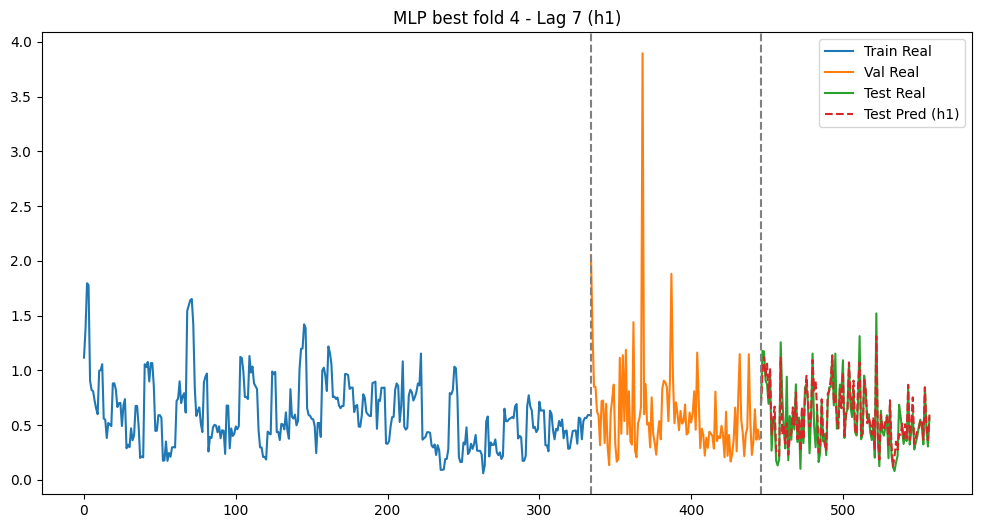

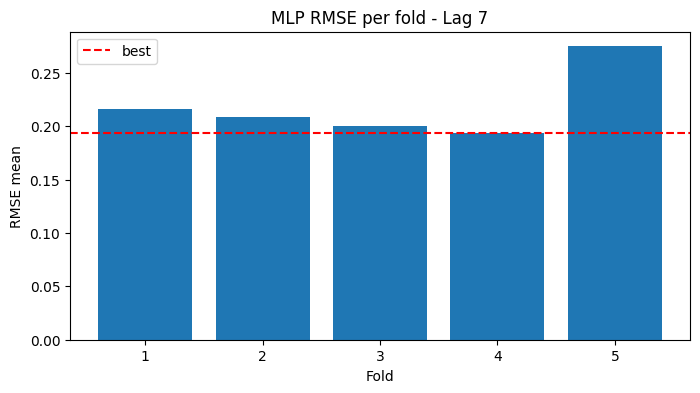

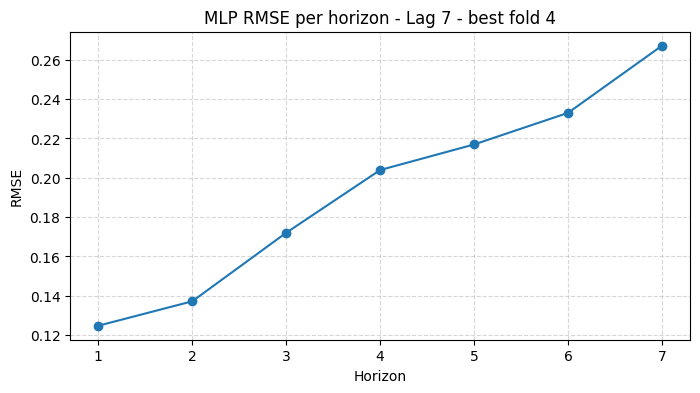

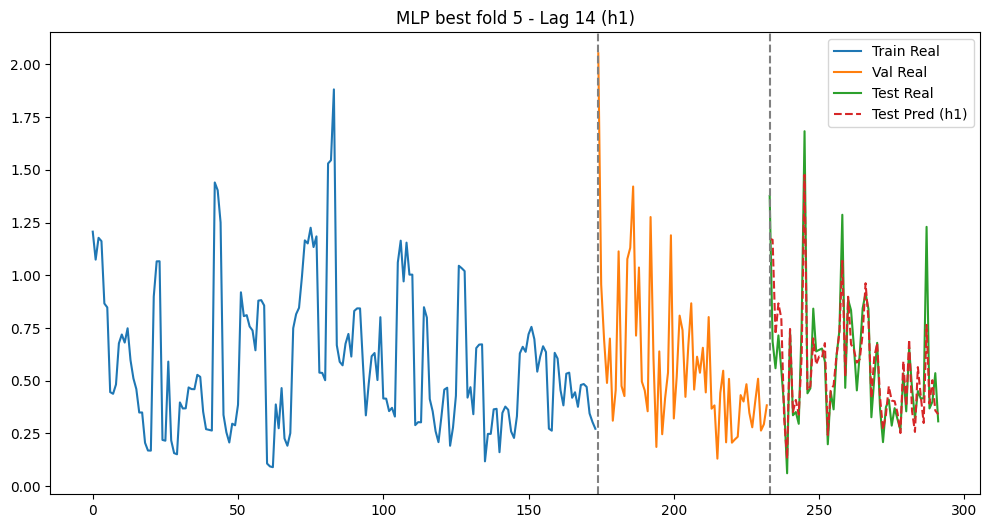

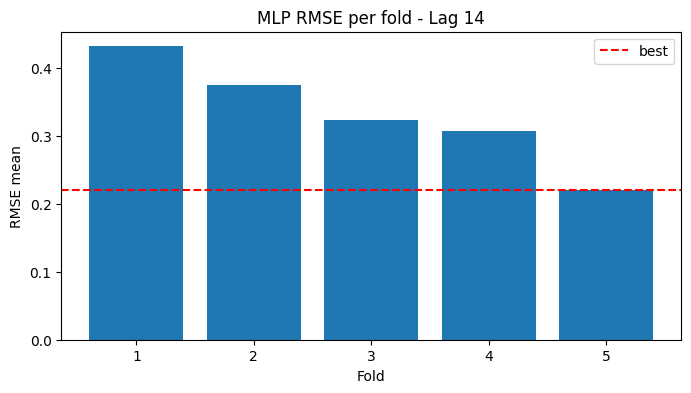

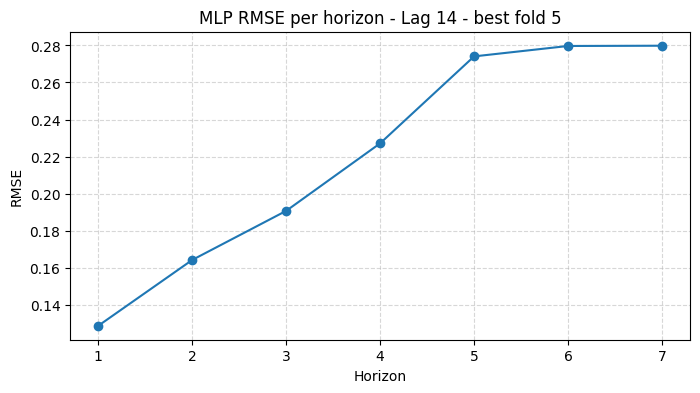

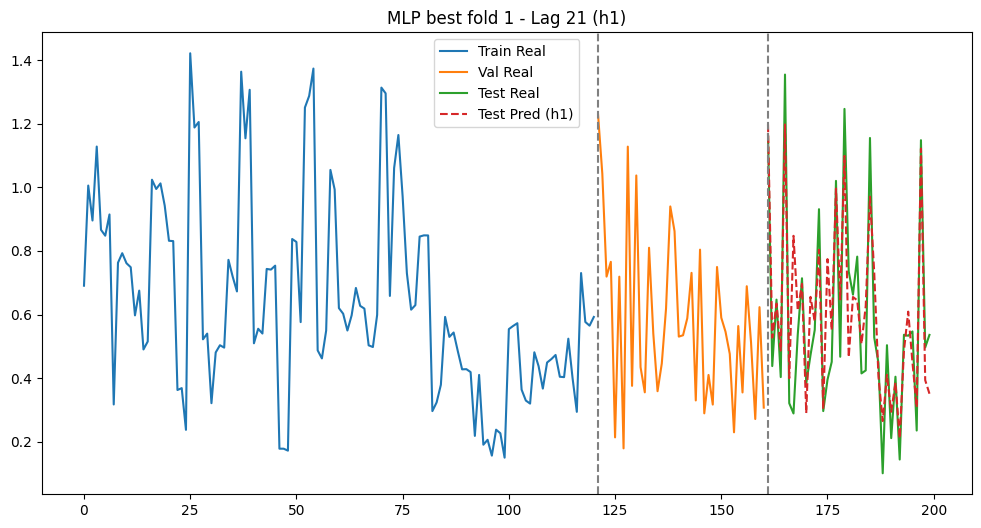

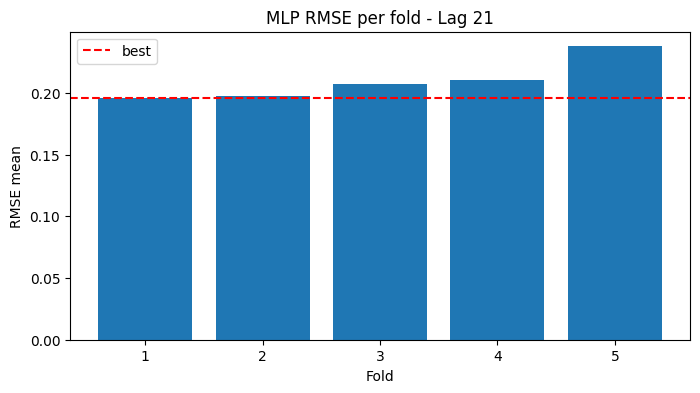

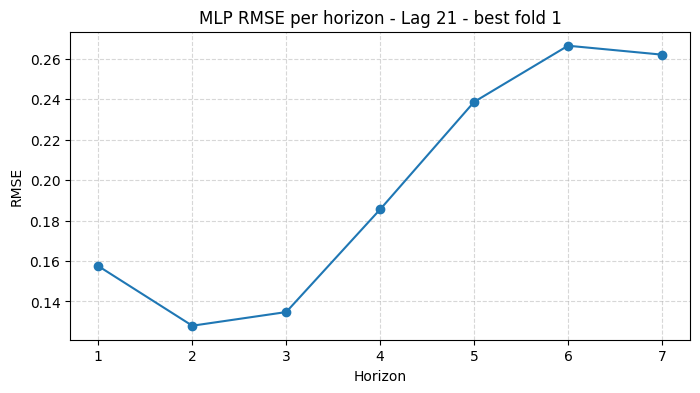

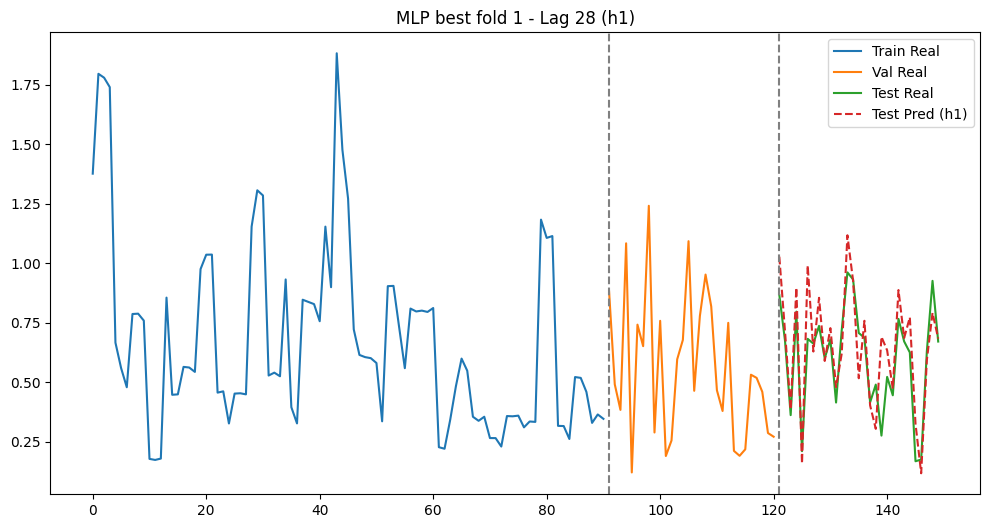

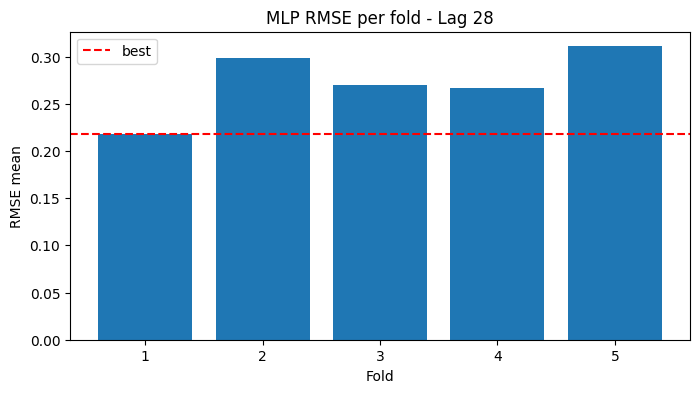

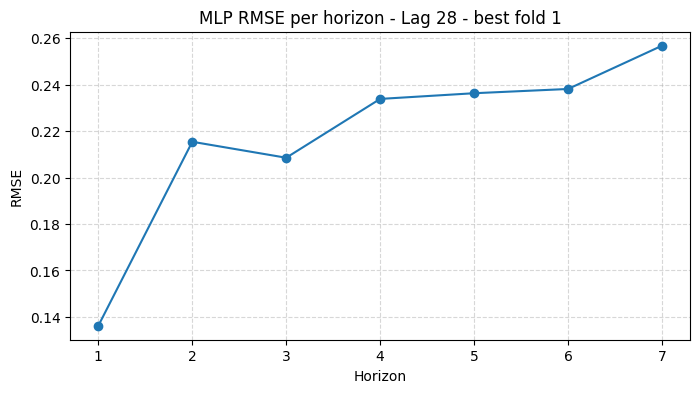

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


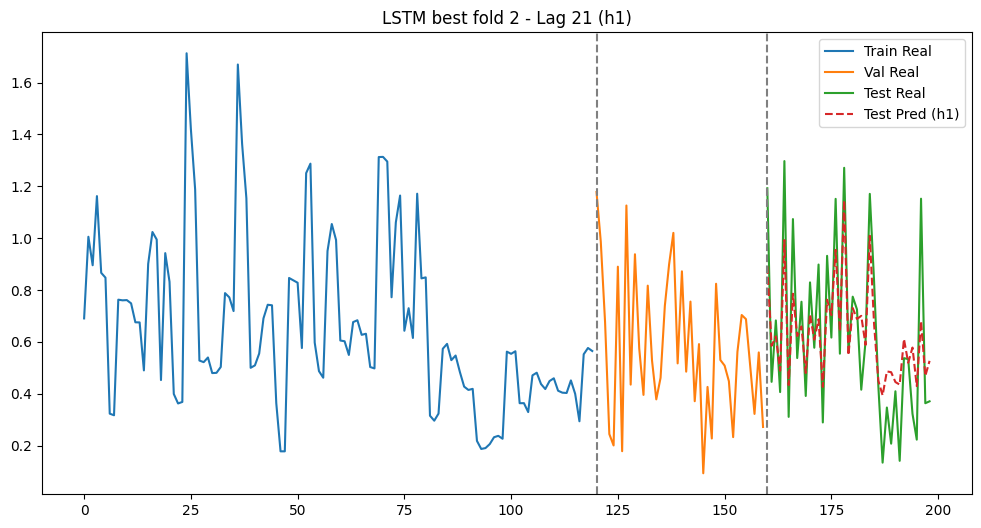

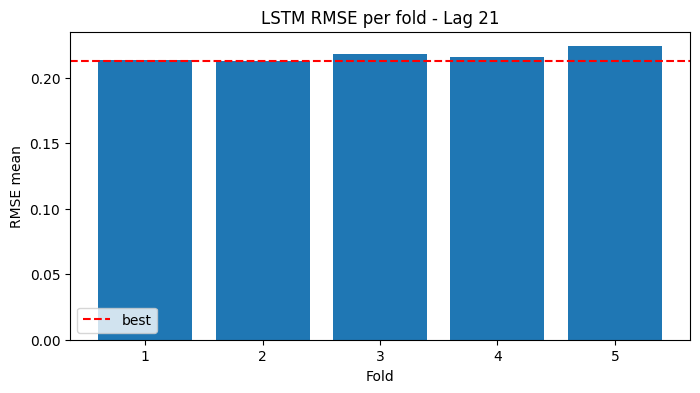

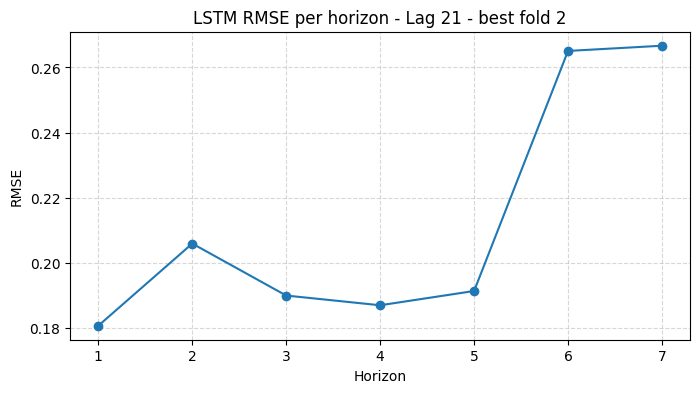

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


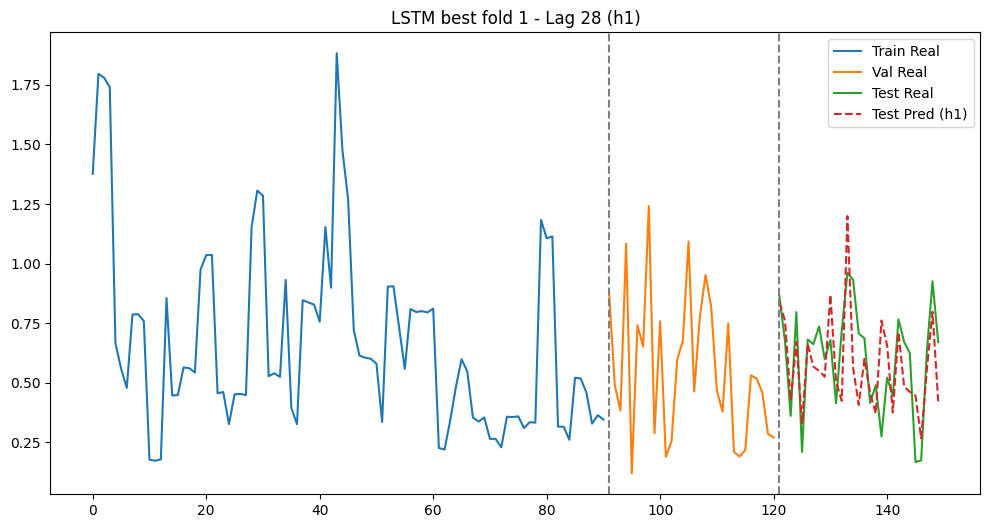

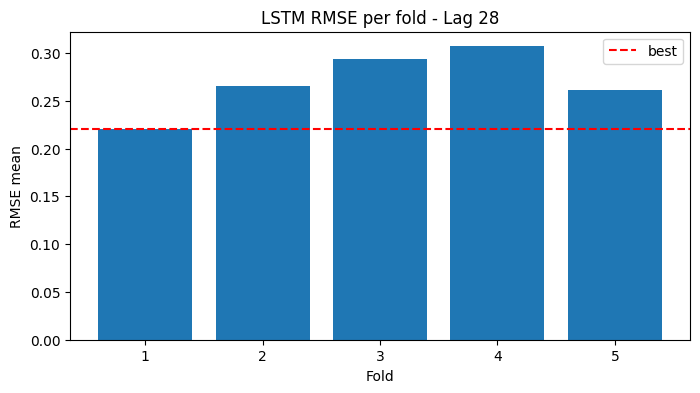

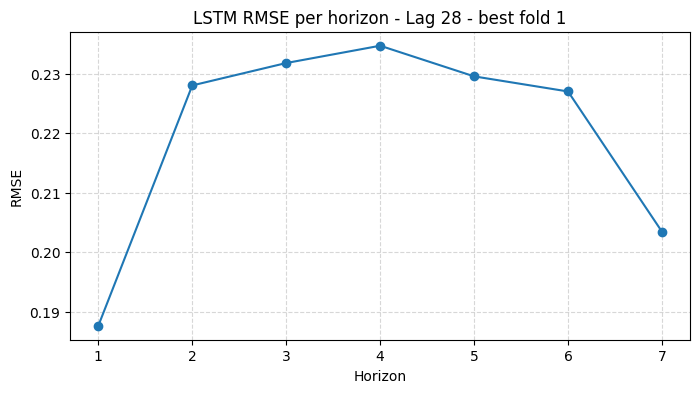


Done. All folds re-trained with provided hyperparams, metrics saved, and best-fold plots generated.


In [1]:
# corregir hiperparam Autocontained: retrain only using provided best hyperparams, collect metrics, produce plots & CSVs.
# Requirements: numpy, pandas, sklearn, tensorflow (keras), matplotlib, tsxv split function available.

import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# ML / preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from collections import Counter

# Keras LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# plotting
import matplotlib.pyplot as plt

# timeseries split
from tsxv.splitTrainValTest import split_train_val_test_groupKFold

# ---------------------------
# Utils
# ---------------------------
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12))) * 100.0

def choose_scaler(kind):
    return StandardScaler() if kind == "standard" else MinMaxScaler(feature_range=(-1,1))

def rmse_per_horiz(y_true, y_pred):
    return np.array([np.sqrt(mean_squared_error(y_true[:,h], y_pred[:,h])) for h in range(y_true.shape[1])])

def bds_test(residuals, max_dim=3, eps_factor=0.5, n_bootstrap=200, random_state=42):
    """Return DataFrame indexed by m with columns statistic and p_value. Handles short samples."""
    import numpy as _np
    import pandas as _pd
    _np.random.seed(random_state)
    n = len(residuals)
    if n < 10:
        return _pd.DataFrame([(2, _np.nan, _np.nan)], columns=['m','statistic','p_value']).set_index('m')
    eps = eps_factor * _np.std(residuals)

    def embed(data, m):
        return _np.array([data[i:i + m] for i in range(n - m + 1)])

    def correlation_integral(X, eps):
        N = len(X)
        if N == 0:
            return 0.0
        count = 0
        for i in range(N):
            count += _np.sum(_np.linalg.norm(X - X[i], axis=1) < eps)
        return count / (N * N)

    results = []
    for m in range(2, max_dim + 1):
        Xm = embed(residuals, m)
        X1 = embed(residuals, 1)
        Cm = correlation_integral(Xm, eps)
        C1 = correlation_integral(X1, eps)
        bds_stat = _np.sqrt(n) * (Cm - C1**m)

        boot_stats = []
        for _ in range(n_bootstrap):
            shuffled = _np.random.permutation(residuals)
            Xm_boot = embed(shuffled, m)
            Cmb = correlation_integral(Xm_boot, eps)
            C1b = correlation_integral(embed(shuffled, 1), eps)
            boot_stats.append(_np.sqrt(n) * (Cmb - C1b**m))
        boot_stats = _np.array(boot_stats)
        p_value = ( _np.sum(_np.abs(boot_stats) >= _np.abs(bds_stat)) + 1 ) / (n_bootstrap + 1)
        results.append((m, bds_stat, p_value))

    return pd.DataFrame(results, columns=['m','statistic','p_value']).set_index('m')

# ---------------------------
# Load data (exactly as requested)
# ---------------------------
btc = pd.read_csv("btc_1d_data_2018_to_2025.csv")
btc = btc[["Open time", "Close"]].dropna().reset_index(drop=True)
btc = btc.rename(columns={"Open time": "Date"})
btc["Close"] = btc["Close"].astype(float)
btc["LogReturn"] = np.log(btc["Close"] / btc["Close"].shift(1))
window_size = 7
btc["Volatility"] = btc["LogReturn"].rolling(window=window_size).std() * np.sqrt(365)
btc = btc.sort_values("Date").reset_index(drop=True).dropna().reset_index(drop=True)
volatility_full = btc["Volatility"].values

# create directories
os.makedirs("notebooks/figs/mlp", exist_ok=True)
os.makedirs("notebooks/figs/lstm", exist_ok=True)
os.makedirs("results/mlp", exist_ok=True)
os.makedirs("results/lstm", exist_ok=True)

# ---------------------------
# Best hyperparams (you provided these earlier)
# ---------------------------
best_cfgs_mlp = {
    7:  {'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 1e-05, 'learning_rate_init': 0.005, 'max_iter': 500, 'scaler': 'standard'},
    14: {'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 0.01, 'learning_rate_init': 0.001, 'max_iter': 500, 'scaler': 'standard'},
    21: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'alpha': 0.0001, 'learning_rate_init': 0.001, 'max_iter': 500, 'scaler': 'standard'},
    28: {'hidden_layer_sizes': (200,), 'activation': 'relu', 'alpha': 0.001, 'learning_rate_init': 0.001, 'max_iter': 500, 'scaler': 'standard'},
}

best_cfgs_lstm = {
    21: {'units': 32, 'dropout': 0.2, 'lr': 0.0005, 'batch_size': 32, 'epochs': 50, 'n_layers': 1},
    28: {'units': 64, 'dropout': 0.0, 'lr': 0.001, 'batch_size': 32, 'epochs': 50, 'n_layers': 1},
}

# ---------------------------
# Functions to build & fit final models (train on train+val)
# ---------------------------
def build_and_fit_mlp(X_train, y_train, cfg):
    scaler_x = choose_scaler(cfg.get("scaler","standard"))
    scaler_y = choose_scaler(cfg.get("scaler","standard"))
    Xs = scaler_x.fit_transform(X_train)
    ys = scaler_y.fit_transform(y_train)
    model = MLPRegressor(hidden_layer_sizes=cfg["hidden_layer_sizes"],
                         activation=cfg["activation"],
                         alpha=cfg["alpha"],
                         learning_rate_init=cfg["learning_rate_init"],
                         max_iter=cfg["max_iter"],
                         random_state=42)
    model.fit(Xs, ys)
    return model, scaler_x, scaler_y

def build_and_fit_lstm(X_train, y_train, cfg):
    # scaler
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    Xs = scaler_x.fit_transform(X_train)
    ys = scaler_y.fit_transform(y_train)
    # reshape for LSTM
    Xs_r = Xs.reshape((Xs.shape[0], Xs.shape[1], 1))
    # build model
    tf.random.set_seed(42)
    model = Sequential()
    if cfg.get("n_layers",1) == 1:
        model.add(LSTM(cfg["units"], input_shape=(Xs_r.shape[1], 1), return_sequences=False))
        if cfg["dropout"] > 0:
            model.add(Dropout(cfg["dropout"]))
    else:
        model.add(LSTM(cfg["units"], input_shape=(Xs_r.shape[1], 1), return_sequences=True))
        if cfg["dropout"] > 0:
            model.add(Dropout(cfg["dropout"]))
        model.add(LSTM(cfg["units"], return_sequences=False))
        if cfg["dropout"] > 0:
            model.add(Dropout(cfg["dropout"]))
    model.add(Dense(ys.shape[1]))
    opt = Adam(learning_rate=cfg["lr"])
    model.compile(loss="mse", optimizer=opt)
    model.fit(Xs_r, ys, epochs=cfg["epochs"], batch_size=cfg["batch_size"], verbose=0)
    return model, scaler_x, scaler_y

# ---------------------------
# Run retrain-only pipeline: MLP (lags 7,14,21,28), LSTM (21,28)
# For each fold: retrain on train+val with best_cfg, evaluate on test, store final_model & scalers for plotting
# ---------------------------
n_steps_out = 7
n_steps_jump = 1

folds_stats_dict = {"mlp": {}, "lstm": {}}
summary_rows = {"mlp": [], "lstm": []}

# Helper to summarize per-fold->summary
def summarize_folds(folds_stats):
    mae_arr = np.array([f["mae_mean"] for f in folds_stats])
    mse_arr = np.array([f["mse_mean"] for f in folds_stats])
    rmse_arr= np.array([f["rmse_mean"] for f in folds_stats])
    mape_arr= np.array([f["mape_mean"] for f in folds_stats])
    bds_arr = np.array([f.get("bds_pval_h1", np.nan) for f in folds_stats])
    return {
        "MAE_mean": float(np.mean(mae_arr)), "MAE_std": float(np.std(mae_arr)),
        "MSE_mean": float(np.mean(mse_arr)), "MSE_std": float(np.std(mse_arr)),
        "RMSE_mean": float(np.mean(rmse_arr)), "RMSE_std": float(np.std(rmse_arr)),
        "MAPE_mean": float(np.mean(mape_arr)), "MAPE_std": float(np.std(mape_arr)),
        "BDS_mean": float(np.nanmean(bds_arr)), "BDS_std": float(np.nanstd(bds_arr))
    }

# --- MLP ---
for lag, cfg in best_cfgs_mlp.items():
    print(f"\n>>> MLP: retraining & evaluating lag={lag}")
    Xs, ys, Xcvs, ycvs, Xtests, ytests = split_train_val_test_groupKFold(volatility_full, lag, n_steps_out, n_steps_jump)
    folds_stats = []
    for fi in range(len(Xs)):
        Xtr, ytr = Xs[fi], ys[fi]
        Xval, yval = Xcvs[fi], ycvs[fi]
        Xte, yte = Xtests[fi], ytests[fi]

        # retrain on train+val
        Xtrain_full = np.vstack([Xtr, Xval])
        ytrain_full = np.vstack([ytr, yval])
        final_model, scaler_x, scaler_y = build_and_fit_mlp(Xtrain_full, ytrain_full, cfg)

        # predict on test
        Xte_s = scaler_x.transform(Xte)
        yhat = scaler_y.inverse_transform(final_model.predict(Xte_s))
        # metrics per horizon
        per_h = []
        for h in range(n_steps_out):
            mae_h = mean_absolute_error(yte[:,h], yhat[:,h])
            mse_h = mean_squared_error(yte[:,h], yhat[:,h])
            rmse_h = np.sqrt(mse_h)
            mape_h = mape(yte[:,h], yhat[:,h])
            per_h.append((mae_h, mse_h, rmse_h, mape_h))

        mae_mean = np.mean([p[0] for p in per_h])
        mse_mean = np.mean([p[1] for p in per_h])
        rmse_mean= np.mean([p[2] for p in per_h])
        mape_mean= np.mean([p[3] for p in per_h])

        # bds on residuals horizon1
        resid_h1 = yte[:,0] - yhat[:,0]
        bds_df = bds_test(resid_h1, n_bootstrap=200)
        try:
            bds_pval = float(bds_df.loc[2, "p_value"])
        except Exception:
            bds_pval = np.nan

        folds_stats.append({
            "fold": fi+1,
            "best_cfg": cfg,
            "final_model": final_model,
            "scaler_x": scaler_x,
            "scaler_y": scaler_y,
            "per_h_metrics": per_h,
            "mae_mean": float(mae_mean),
            "mse_mean": float(mse_mean),
            "rmse_mean": float(rmse_mean),
            "mape_mean": float(mape_mean),
            "bds_pval_h1": bds_pval
        })
        print(f"  fold {fi+1}: RMSE={rmse_mean:.4f}, MAPE={mape_mean:.2f} (saved model in memory)")

    folds_stats_dict["mlp"][lag] = folds_stats
    summary = summarize_folds(folds_stats)
    summary["Lag"] = lag
    summary["Best_cfg_mode"] = str(cfg)
    summary_rows["mlp"].append(summary)
    # save per-lag CSV
    df_f = pd.DataFrame([{k:v for k,v in f.items() if k not in ('final_model','scaler_x','scaler_y')} for f in folds_stats])
    df_f.to_csv(f"results/mlp/folds_metrics_lag{lag}.csv", index=False)
    print(f"[saved] results/mlp/folds_metrics_lag{lag}.csv")

# --- LSTM ---
for lag, cfg in best_cfgs_lstm.items():
    print(f"\n>>> LSTM: retraining & evaluating lag={lag}")
    Xs, ys, Xcvs, ycvs, Xtests, ytests = split_train_val_test_groupKFold(volatility_full, lag, n_steps_out, n_steps_jump)
    folds_stats = []
    for fi in range(len(Xs)):
        Xtr, ytr = Xs[fi], ys[fi]
        Xval, yval = Xcvs[fi], ycvs[fi]
        Xte, yte = Xtests[fi], ytests[fi]

        # retrain on train+val
        Xtrain_full = np.vstack([Xtr, Xval])
        ytrain_full = np.vstack([ytr, yval])
        final_model, scaler_x, scaler_y = build_and_fit_lstm(Xtrain_full, ytrain_full, cfg)

        # predict on test (reshape)
        Xte_s = scaler_x.transform(Xte).reshape((Xte.shape[0], Xte.shape[1], 1))
        yhat = scaler_y.inverse_transform(final_model.predict(Xte_s))

        # per-h metrics
        per_h = []
        for h in range(n_steps_out):
            mae_h = mean_absolute_error(yte[:,h], yhat[:,h])
            mse_h = mean_squared_error(yte[:,h], yhat[:,h])
            rmse_h = np.sqrt(mse_h)
            mape_h = mape(yte[:,h], yhat[:,h])
            per_h.append((mae_h, mse_h, rmse_h, mape_h))

        mae_mean = np.mean([p[0] for p in per_h])
        mse_mean = np.mean([p[1] for p in per_h])
        rmse_mean= np.mean([p[2] for p in per_h])
        mape_mean= np.mean([p[3] for p in per_h])

        resid_h1 = yte[:,0] - yhat[:,0]
        bds_df = bds_test(resid_h1, n_bootstrap=200)
        try:
            bds_pval = float(bds_df.loc[2, "p_value"])
        except Exception:
            bds_pval = np.nan

        folds_stats.append({
            "fold": fi+1,
            "best_cfg": cfg,
            "final_model": final_model,
            "scaler_x": scaler_x,
            "scaler_y": scaler_y,
            "per_h_metrics": per_h,
            "mae_mean": float(mae_mean),
            "mse_mean": float(mse_mean),
            "rmse_mean": float(rmse_mean),
            "mape_mean": float(mape_mean),
            "bds_pval_h1": bds_pval
        })
        print(f"  fold {fi+1}: RMSE={rmse_mean:.4f}, MAPE={mape_mean:.2f} (saved model in memory)")

    folds_stats_dict["lstm"][lag] = folds_stats
    summary = summarize_folds(folds_stats)
    summary["Lag"] = lag
    summary["Best_cfg_mode"] = str(cfg)
    summary_rows["lstm"].append(summary)
    df_f = pd.DataFrame([{k:v for k,v in f.items() if k not in ('final_model','scaler_x','scaler_y')} for f in folds_stats])
    df_f.to_csv(f"results/lstm/folds_metrics_lag{lag}.csv", index=False)
    print(f"[saved] results/lstm/folds_metrics_lag{lag}.csv")

# ---------------------------
# Save summary CSVs
# ---------------------------
pd.DataFrame(summary_rows["mlp"]).to_csv("results/mlp/summary_metrics.csv", index=False)
pd.DataFrame(summary_rows["lstm"]).to_csv("results/lstm/summary_metrics.csv", index=False)
print("\n[Saved summary CSVs] results/mlp/summary_metrics.csv, results/lstm/summary_metrics.csv")

# ---------------------------
# Visualization: for each model+lag, plot best fold (by rmse_mean)
# ---------------------------
def plot_best_fold_for_model(model_key, lag):
    folds_stats = folds_stats_dict[model_key][lag]
    # pick best fold (lowest rmse_mean)
    rmse_arr = np.array([f["rmse_mean"] for f in folds_stats])
    best_idx = int(np.argmin(rmse_arr))
    entry = folds_stats[best_idx]

    # recover data splits for this lag
    Xs, ys, Xcvs, ycvs, Xtests, ytests = split_train_val_test_groupKFold(volatility_full, lag, n_steps_out, n_steps_jump)
    Xtr, ytr = Xs[best_idx], ys[best_idx]
    Xval, yval = Xcvs[best_idx], ycvs[best_idx]
    Xte, yte = Xtests[best_idx], ytests[best_idx]

    # model + scalers
    model_obj = entry["final_model"]
    scaler_x = entry["scaler_x"]
    scaler_y = entry["scaler_y"]

    # predict
    if model_key == "lstm":
        Xte_s = scaler_x.transform(Xte).reshape((Xte.shape[0], Xte.shape[1], 1))
        yhat = scaler_y.inverse_transform(model_obj.predict(Xte_s))
    else:
        Xte_s = scaler_x.transform(Xte)
        yhat = scaler_y.inverse_transform(model_obj.predict(Xte_s))

    # 1) time series (h1)
    plt.figure(figsize=(12,6))
    plt.plot(ytr[:,0], label="Train Real")
    plt.plot(range(len(ytr), len(ytr)+len(yval)), yval[:,0], label="Val Real")
    plt.plot(range(len(ytr)+len(yval), len(ytr)+len(yval)+len(yte)), yte[:,0], label="Test Real")
    plt.plot(range(len(ytr)+len(yval), len(ytr)+len(yval)+len(yte)), yhat[:,0], label="Test Pred (h1)", linestyle="--")
    plt.axvline(len(ytr), color="gray", linestyle="--")
    plt.axvline(len(ytr)+len(yval), color="gray", linestyle="--")
    plt.legend()
    plt.title(f"{model_key.upper()} best fold {best_idx+1} - Lag {lag} (h1)")
    plt.savefig(f"notebooks/figs/{model_key}/{model_key}_series_lag{lag}_bestfold{best_idx+1}.png", dpi=300, bbox_inches="tight")
    plt.show()

    # 2) RMSE per fold bars
    plt.figure(figsize=(8,4))
    plt.bar(range(1, len(rmse_arr)+1), rmse_arr)
    plt.axhline(rmse_arr[best_idx], color="red", linestyle="--", label="best")
    plt.xlabel("Fold")
    plt.ylabel("RMSE mean")
    plt.title(f"{model_key.upper()} RMSE per fold - Lag {lag}")
    plt.legend()
    plt.savefig(f"notebooks/figs/{model_key}/{model_key}_rmse_per_fold_lag{lag}.png", dpi=300, bbox_inches="tight")
    plt.show()

    # 3) RMSE per horizon for that best fold
    rmse_h = rmse_per_horiz(yte, yhat)
    plt.figure(figsize=(8,4))
    plt.plot(range(1, len(rmse_h)+1), rmse_h, marker="o")
    plt.xlabel("Horizon")
    plt.ylabel("RMSE")
    plt.title(f"{model_key.upper()} RMSE per horizon - Lag {lag} - best fold {best_idx+1}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.savefig(f"notebooks/figs/{model_key}/{model_key}_rmse_per_horizon_lag{lag}_bestfold{best_idx+1}.png", dpi=300, bbox_inches="tight")
    plt.show()

# plot all
for lag in best_cfgs_mlp.keys():
    plot_best_fold_for_model("mlp", lag)
for lag in best_cfgs_lstm.keys():
    plot_best_fold_for_model("lstm", lag)

print("\nDone. All folds re-trained with provided hyperparams, metrics saved, and best-fold plots generated.")


en estos graficos observamos que, mayormente , el error suele aumentar conforme nos movemos a la derecha en la prediccion, lo cual es consistente con lo esperado por la propagacion de errores.
algo interesante ocurre con los dos modelos lstm, en los cuales en lag de tamano 21 se mantiene bastante estable el error hasta la ultima prediccion y en el lag 28 que hace un arco, es posible que en el modelo de 28 dias este capturando algun patron a largo plazo de la serie de tiempo de la volatilidad, pero requeririamos de pruebas mas extensas para comprobar.